In [29]:
import torch
import src.unet.model as model

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.unet.satellite_image import SatelliteImage
from src.unet.dataloader import SatelliteDataset, LabelledSatelliteDataset
from src.unet.normalisers import IdentityNormaliser
from rasterio.plot import reshape_as_image

from src.constants import SRC_PATH, GWS_DATA_DIR, WGS84, UTM35N, SENTINEL_DIR
SENTINEL_POLESIA_DIR = SENTINEL_DIR / "Polesia_10m"
SENTINEL_CHERNOBYL_DIR = SENTINEL_DIR / "Chernobyl_10m"

from src.constants import PROJECT_PATH

In [2]:
tile_size = 256
images_path = SENTINEL_POLESIA_DIR / "train_summer"
labels_path = GWS_DATA_DIR / "polesia_burned_superclasses_all_touched_10m.tif"
use_bands = [0,1,2,3,4,5,6,7,8,9]

dataset = SatelliteDataset(images_path=images_path,
                           use_bands=use_bands,
                           tile_size=tile_size,
                           normaliser=IdentityNormaliser(),)

labelled_dataset = LabelledSatelliteDataset(images_path=images_path,
                                            labels_path=labels_path, 
                                            use_bands=use_bands,
                                            tile_size=256,
                                            n_classes=20,
                                            normaliser=IdentityNormaliser(),
                                            overlap_threshold=0.95)

In [87]:
unet = model.UNetModel.load_from_checkpoint(PROJECT_PATH / "logs/100-ep-deep-10bands-summer_only/checkpoints/epoch=137.ckpt")

In [88]:
def plot_tile(tile, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1)
    plt.imshow(reshape_as_image(tile[[2,1,0], ...]))

def predict(idx, dataset=labelled_dataset):
    
    tile, y_true_logits = dataset[idx]
    
    y_pred_logits = unet.predict(tile[None, ...].float(), 1)
    y_pred = np.argmax(y_pred_logits.detach().numpy().squeeze(), axis=0)
    
    y_true = np.argmax(y_true_logits.numpy().squeeze(), axis=0)   
    
    return tile.numpy().squeeze(), y_pred, y_true

def discrete_matshow(data, ax = None, with_colorbar=False):
    if ax is None:
        fig, ax = plt.subplots(1)
    #get discrete colormap
    cmap = plt.get_cmap('tab20', 20)
    # set limits .5 outside true range
    mat = ax.matshow(data, cmap=cmap, vmin = 0-.5, vmax = 19+.5)
    #tell the colorbar to tick at integers
    if with_colorbar:
        cax = plt.colorbar(mat, ticks=np.arange(0,20))
    return mat

In [89]:
def analyse(idx):
    fig, axes = plt.subplots(ncols=3, figsize=(10,3))
    tile, y_pred, y_true = predict(idx, dataset=labelled_dataset)
    
    axes[0].imshow(reshape_as_image(tile[[2,1,0], ...]))
    axes[0].set_title("Tile")
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    
    mat1 = discrete_matshow(y_pred, ax=axes[1])
    axes[1].set_title("Predicted segmentation")
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    
    mat2 = discrete_matshow(y_true, ax=axes[2])
    axes[2].set_title("True Labels")
    axes[2].get_xaxis().set_visible(False)
    axes[2].get_yaxis().set_visible(False)
    #fig.colorbar(ax=axes[1], location='bottom', ticks=np.arange(0,20))
    #plt.colorbar(axes, ticks=np.arange(0,20))
    cb_ax = fig.add_axes([0.15, 0., 0.7, 0.08])  # left-offset, # bottom offset # width, # height
    cbar = fig.colorbar(mat2, cax=cb_ax, ticks=np.arange(0,20), orientation='horizontal')

     #set the colorbar ticks and tick labels
    cbar.set_ticks(np.arange(0, 20))
    plt.show()
    
    cf_matrix = sklearn.metrics.confusion_matrix(y_true.ravel(), y_pred.ravel())
    f1 = sklearn.metrics.f1_score(y_true.ravel(), y_pred.ravel(), average=None)
    print(f"F1-score (micro): {sklearn.metrics.f1_score(y_true.ravel(), y_pred.ravel(), average='micro')}")
    print(f"F1-score (macro): {sklearn.metrics.f1_score(y_true.ravel(), y_pred.ravel(), average='macro')}")
    print(f"F1-score (weighted): {sklearn.metrics.f1_score(y_true.ravel(), y_pred.ravel(), average='weighted')}")
    
    #print(f"Jaccard-macro: {sklearn.metrics.jaccard_score(y_true, y_pred, average='macro')}")
    #print(f"Jaccard-weighted: {sklearn.metrics.jaccard_score(y_true.ravel(), y_pred.ravel(), average='samples')}")
    return cf_matrix, f1

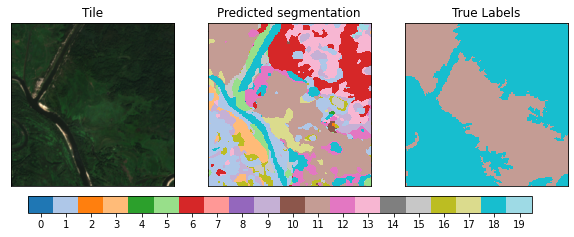

F1-score (micro): 0.325927734375
F1-score (macro): 0.05305522754253676
F1-score (weighted): 0.43820969836936896


In [90]:
cf_matrix, f1 = analyse(0)

In [91]:
np.random.seed(73)
random_tile_indices = np.random.choice(np.arange(len(labelled_dataset)), size=10, replace=False)
print(random_tile_indices)

[574  50 230 463 536 261 343 256  59 257]


Tile: 574


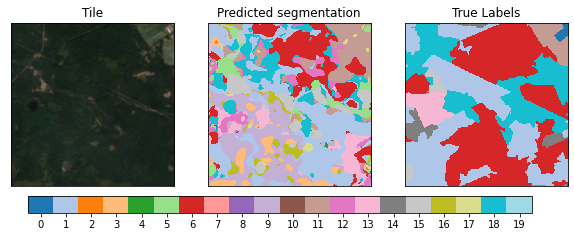

F1-score (micro): 0.2735595703125
F1-score (macro): 0.09397399166385471
F1-score (weighted): 0.31718868446873455
Tile: 50


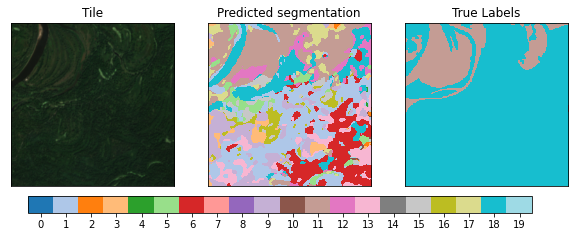

F1-score (micro): 0.17706298828125
F1-score (macro): 0.040578229309449085
F1-score (weighted): 0.2328571445862046
Tile: 230


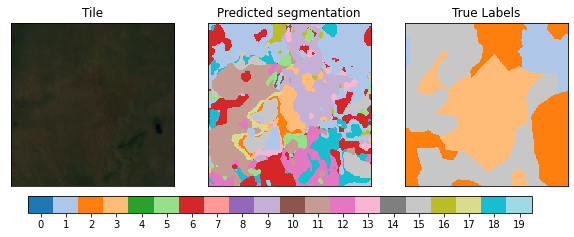

F1-score (micro): 0.126953125
F1-score (macro): 0.04537548813512158
F1-score (weighted): 0.13440221157748
Tile: 463


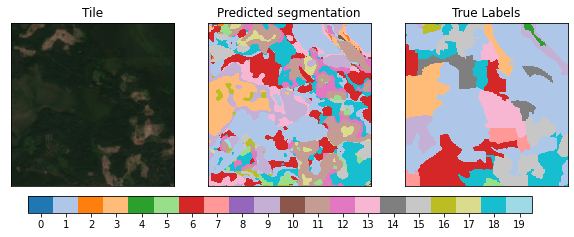

F1-score (micro): 0.29217529296875
F1-score (macro): 0.1179591311088647
F1-score (weighted): 0.3328973390193495
Tile: 536


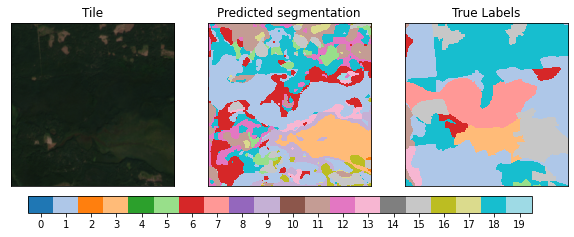

F1-score (micro): 0.24969482421875
F1-score (macro): 0.0813279050010671
F1-score (weighted): 0.2779971040666227
Tile: 261


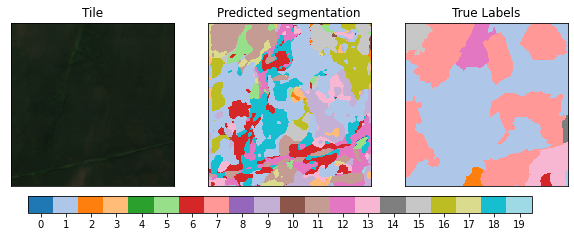

F1-score (micro): 0.1367950439453125
F1-score (macro): 0.031292720847214316
F1-score (weighted): 0.172517227580724
Tile: 343


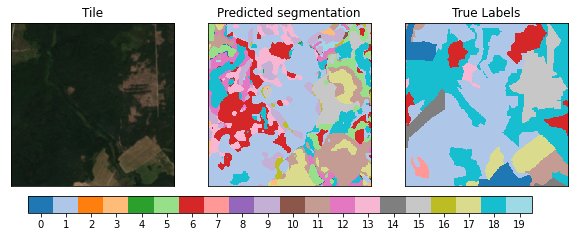

F1-score (micro): 0.35809326171875
F1-score (macro): 0.1219148606337452
F1-score (weighted): 0.4085076791129626
Tile: 256


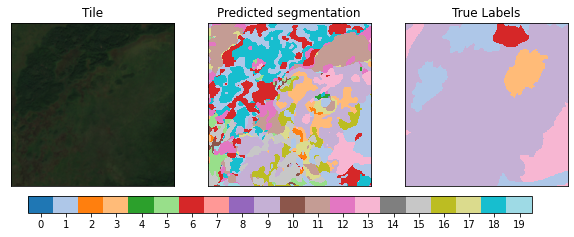

F1-score (micro): 0.2240142822265625
F1-score (macro): 0.05886475805685152
F1-score (weighted): 0.31069371488299535
Tile: 59


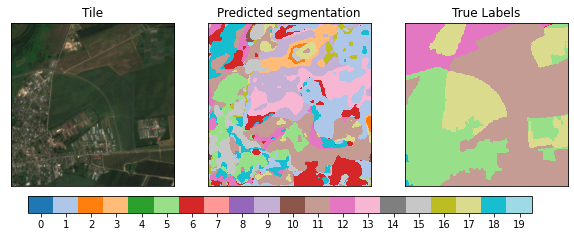

F1-score (micro): 0.148468017578125
F1-score (macro): 0.04716931969418602
F1-score (weighted): 0.22156461502221336
Tile: 257


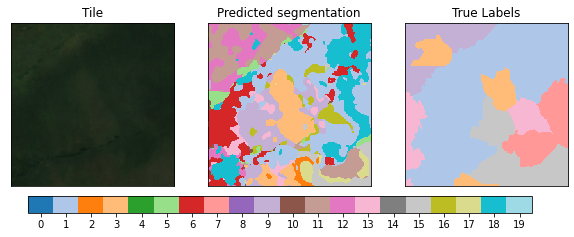

F1-score (micro): 0.1969757080078125
F1-score (macro): 0.0590549446124598
F1-score (weighted): 0.2695852808613681


In [92]:
for index in random_tile_indices:
    print(f"Tile: {index}")
    analyse(index)
    print("\n\n")